In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
%matplotlib inline

In [2]:
## PIfunc that calculate Unique, Synergy and Redundancy of three unsymmetric varibles
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int8')
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:-shift]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[-shift:]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        Redun[i] = sum(np.minimum(PI_xR, PI_vR))/dt
    return timeshift, MIxr, MIvr, MIxvR, Redun

In [24]:
n=50
Syn_l = np.zeros((n,n)) 
Rdn_l = np.zeros((n,n)) 
Ux_l = np.zeros((n,n)) 
Uy_l = np.zeros((n,n)) 
o = np.random.randint(n, size=30000)
for i in range(n):
    for j in range(n):
        x = o + np.random.randint(2*i+3, size=30000)-i-1
        y = o + np.random.randint(2*j+3, size=30000)-j-1
        z = np.random.poisson(o)
        timeshift, MIx, MIv, MIjoint, Redun = PIfunc(z, x, y, 1, [-0,0])
        Syn_l[i,j] = MIjoint-MIx-MIv+Redun
        Rdn_l[i,j] = Redun.copy()
        Ux_l[i,j] = MIx-Redun
        Uy_l[i,j] = MIv-Redun

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\

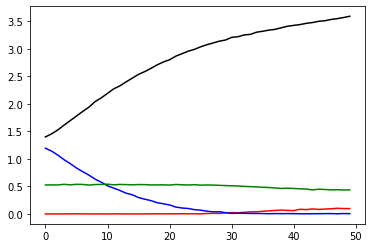

In [33]:
ind = 30
plt.plot(Ux_l[ind,:],'r')
plt.plot(Uy_l[ind,:],'b')
plt.plot(Syn_l[ind,:],'k')
plt.plot(Rdn_l[ind,:],'g')

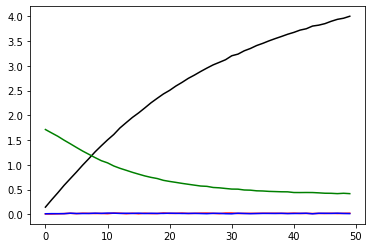

In [32]:
ind = 40
plt.plot(Ux_l.diagonal(),'r')
plt.plot(Uy_l.diagonal(),'b')
plt.plot(Syn_l.diagonal(),'k')
plt.plot(Rdn_l.diagonal(),'g')

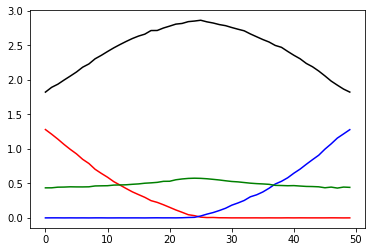

In [34]:
ind = 40
plt.plot(np.fliplr(Ux_l).diagonal(),'r')
plt.plot(np.fliplr(Uy_l).diagonal(),'b')
plt.plot(np.fliplr(Syn_l).diagonal(),'k')
plt.plot(np.fliplr(Rdn_l).diagonal(),'g')